In [165]:
# !unzip CV_project1_data.zip 

In [25]:
import os
import glob 

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

Создадим тренировочный и валидационный датасеты и даталоадеры

In [2]:
PATH_TRAIN = './data/train'
PATH_VALID = './data/valid'

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # transforms.ColorJitter(brightness=.5, hue=.3),
])

transform_valid = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [4]:
train = ImageFolder(PATH_TRAIN, transform=transform_train)
valid = ImageFolder(PATH_VALID, transform=transform_valid)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=False)

Посмотрим на наши данные 

In [5]:
train.classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

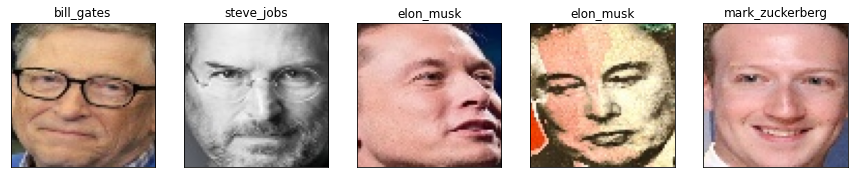

In [30]:
plt.figure(figsize=(15, 7))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    path_img = np.random.choice(glob.glob(os.path.join(PATH_TRAIN, '*/*.jpg')))
    img = plt.imread(path_img)
    plt.title(path_img.split('/')[-2])
    plt.imshow(img)


Загрузим предобученную модель

In [10]:
from torchvision.models import resnet50, resnet34

# model = resnet34(pretrained=True)
model = resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Поменяем последний слой сети

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
# resnet34
# model.fc =  nn.Linear(in_features=512, out_features=len(train.classes), bias=True)

# resnet50
model.fc =  nn.Linear(in_features=2048, out_features=len(train.classes), bias=True)

Тренировки модели

In [16]:
def train_model(model, optimizer, train_dataloader, valid_dataloader, n_epochs=5):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(n_epochs):
        losses = []
        equals = []
        torch.set_grad_enabled(True)
        model.train()

        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            # переносим на GPU при возможности
            imgs = imgs.to(device)
            labels = labels.to(device)

            # считаем сырые предсказания и функцию потерь
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)

            # делаем шаг обновления весов модели
            loss.backward()            
            optimizer.step()
            optimizer.zero_grad()

            # loss и equals
            losses.append(loss.item())
            equals.extend([eq.item() for eq in y_pred.argmax(1) == labels])
            
        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        losses = []
        equals = []
        torch.set_grad_enabled(False)
        model.eval()

        for imgs, labels in tqdm(valid_dataloader, desc=f"Validati, epoch {epoch}", leave=False):
            # переносим на GPU при возможности
            imgs = imgs.to(device)
            labels = labels.to(device)

            # считаем сырые предсказания и функцию потерь
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)

            # loss и equals
            losses.append(loss.item())
            equals.extend([eq.item() for eq in y_pred.argmax(1) == labels])

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss_train[-1]}, Train acc: {top1_train[-1]}, Valid loss: {loss_valid[-1]}, Valid acc {top1_valid[-1]}")

    return loss_train, top1_train, loss_valid, top1_valid

In [18]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [19]:
loss_train, top1_train, loss_valid, top1_valid = train_model(model, optimizer, train_dataloader, valid_dataloader, n_epochs)

Epoch: 0
Train loss: 1.3310672044754028, Train acc: 0.48433333333333334, Valid loss: 1.0500294119119644, Valid acc 0.6564551422319475


Epoch: 1
Train loss: 0.8669800013303757, Train acc: 0.7326666666666667, Valid loss: 0.7104467302560806, Valid acc 0.7647702407002188


Epoch: 2
Train loss: 0.7125901232163111, Train acc: 0.762, Valid loss: 0.6338879317045212, Valid acc 0.7833698030634574


Epoch: 3
Train loss: 0.6335677752892176, Train acc: 0.793, Valid loss: 0.5868357196450233, Valid acc 0.8194748358862144


Epoch: 4
Train loss: 0.5825314844648043, Train acc: 0.8036666666666666, Valid loss: 0.5434350594878197, Valid acc 0.8271334792122538


Epoch: 5
Train loss: 0.5451574549078941, Train acc: 0.8206666666666667, Valid loss: 0.4908999428153038, Valid acc 0.838074398249453


Epoch: 6
Train loss: 0.5077846199274063, Train acc: 0.838, Valid loss: 0.46638011187314987, Valid acc 0.8479212253829321


Epoch: 7
Train loss: 0.487652746339639, Train acc: 0.8433333333333334, Valid loss: 0.45214154571294785, Valid acc 0.8413566739606126


Epoch: 8
Train loss: 0.4506119464834531, Train acc: 0.8576666666666667, Valid loss: 0.4526580572128296, Valid acc 0.8512035010940919


Epoch: 9
Train loss: 0.45489660898844403, Train acc: 0.855, Valid loss: 0.4289794936776161, Valid acc 0.8708971553610503


Epoch: 10
Train loss: 0.451712225874265, Train acc: 0.8546666666666667, Valid loss: 0.41743552684783936, Valid acc 0.8566739606126915


Epoch: 11
Train loss: 0.41670704384644824, Train acc: 0.8673333333333333, Valid loss: 0.4157085493206978, Valid acc 0.8632385120350109


Epoch: 12
Train loss: 0.41057969133059186, Train acc: 0.8786666666666667, Valid loss: 0.4088756889104843, Valid acc 0.8588621444201313


Epoch: 13
Train loss: 0.4084952225287755, Train acc: 0.8693333333333333, Valid loss: 0.3997945711016655, Valid acc 0.8687089715536105


Epoch: 14
Train loss: 0.40874509265025455, Train acc: 0.868, Valid loss: 0.39229243248701096, Valid acc 0.8654266958424508


Epoch: 15
Train loss: 0.3957146182656288, Train acc: 0.8786666666666667, Valid loss: 0.40636323392391205, Valid acc 0.8555798687089715


Epoch: 16
Train loss: 0.38774701952934265, Train acc: 0.881, Valid loss: 0.4104382023215294, Valid acc 0.8577680525164114


Epoch: 17
Train loss: 0.38104740530252457, Train acc: 0.879, Valid loss: 0.389301061630249, Valid acc 0.8719912472647703


Epoch: 18
Train loss: 0.3747815315922101, Train acc: 0.8846666666666667, Valid loss: 0.38750670477747917, Valid acc 0.8719912472647703


Epoch: 19
Train loss: 0.38191280017296475, Train acc: 0.8733333333333333, Valid loss: 0.3674165830016136, Valid acc 0.8687089715536105


Epoch: 20
Train loss: 0.3567350208759308, Train acc: 0.883, Valid loss: 0.37553391605615616, Valid acc 0.8654266958424508


Epoch: 21
Train loss: 0.3685816824436188, Train acc: 0.8776666666666667, Valid loss: 0.3633192181587219, Valid acc 0.8763676148796499


Epoch: 22
Train loss: 0.348537415266037, Train acc: 0.8856666666666667, Valid loss: 0.3697592057287693, Valid acc 0.8687089715536105


Epoch: 23
Train loss: 0.3409133031964302, Train acc: 0.8896666666666667, Valid loss: 0.3470029681921005, Valid acc 0.888402625820569


Epoch: 24
Train loss: 0.33596084515253705, Train acc: 0.8933333333333333, Valid loss: 0.34489738941192627, Valid acc 0.8807439824945296


Epoch: 25
Train loss: 0.3239353969693184, Train acc: 0.9043333333333333, Valid loss: 0.34095895662903786, Valid acc 0.8851203501094091


Epoch: 26
Train loss: 0.3205973158280055, Train acc: 0.8933333333333333, Valid loss: 0.34222712367773056, Valid acc 0.8818380743982495


Epoch: 27
Train loss: 0.3170158192515373, Train acc: 0.9003333333333333, Valid loss: 0.33396103605628014, Valid acc 0.8905908096280087


Epoch: 28
Train loss: 0.31325102349122363, Train acc: 0.905, Valid loss: 0.32638663426041603, Valid acc 0.8971553610503282


Epoch: 29
Train loss: 0.2976115942001343, Train acc: 0.9046666666666666, Valid loss: 0.3284641392529011, Valid acc 0.8982494529540481


Epoch: 30
Train loss: 0.31004783262809116, Train acc: 0.91, Valid loss: 0.32813695445656776, Valid acc 0.8949671772428884


Epoch: 31
Train loss: 0.3068612093726794, Train acc: 0.9066666666666666, Valid loss: 0.3383103311061859, Valid acc 0.8818380743982495


Epoch: 32
Train loss: 0.30758582179745037, Train acc: 0.9043333333333333, Valid loss: 0.3516196869313717, Valid acc 0.8807439824945296


Epoch: 33
Train loss: 0.29574718202153844, Train acc: 0.9076666666666666, Valid loss: 0.32066915929317474, Valid acc 0.8949671772428884


Epoch: 34
Train loss: 0.29210250452160835, Train acc: 0.9136666666666666, Valid loss: 0.31723128259181976, Valid acc 0.8927789934354485


Epoch: 35
Train loss: 0.28399061039090157, Train acc: 0.9126666666666666, Valid loss: 0.3244641348719597, Valid acc 0.8960612691466083


Epoch: 36
Train loss: 0.2907272105415662, Train acc: 0.9183333333333333, Valid loss: 0.3150004372000694, Valid acc 0.8894967177242888


Epoch: 37
Train loss: 0.277461680273215, Train acc: 0.916, Valid loss: 0.33511369302868843, Valid acc 0.8916849015317286


Epoch: 38
Train loss: 0.3000331073999405, Train acc: 0.9133333333333333, Valid loss: 0.3239023983478546, Valid acc 0.888402625820569


Epoch: 39
Train loss: 0.28699663902322453, Train acc: 0.9113333333333333, Valid loss: 0.3244849853217602, Valid acc 0.8905908096280087


Epoch: 40
Train loss: 0.2784675657749176, Train acc: 0.9103333333333333, Valid loss: 0.322018351405859, Valid acc 0.8971553610503282


Epoch: 41
Train loss: 0.26790251582860947, Train acc: 0.917, Valid loss: 0.3161647841334343, Valid acc 0.899343544857768


Epoch: 42
Train loss: 0.26454176381230354, Train acc: 0.9206666666666666, Valid loss: 0.31579768657684326, Valid acc 0.8949671772428884


Epoch: 43
Train loss: 0.2759120501577854, Train acc: 0.912, Valid loss: 0.3157897777855396, Valid acc 0.9026258205689278


Epoch: 44
Train loss: 0.26354555661479634, Train acc: 0.9176666666666666, Valid loss: 0.3031686395406723, Valid acc 0.8971553610503282


Epoch: 45
Train loss: 0.27209507922331494, Train acc: 0.9176666666666666, Valid loss: 0.30388038977980614, Valid acc 0.8982494529540481


Epoch: 46
Train loss: 0.2552955262362957, Train acc: 0.926, Valid loss: 0.31540533527731895, Valid acc 0.8971553610503282


Epoch: 47
Train loss: 0.2789363997677962, Train acc: 0.9093333333333333, Valid loss: 0.3006879612803459, Valid acc 0.9015317286652079


Epoch: 48
Train loss: 0.2546235645810763, Train acc: 0.9226666666666666, Valid loss: 0.3032678887248039, Valid acc 0.9015317286652079


Epoch: 49
Train loss: 0.2626442251106103, Train acc: 0.9186666666666666, Valid loss: 0.3028174750506878, Valid acc 0.8960612691466083


Посмотрим на графики логов лосса и метрики

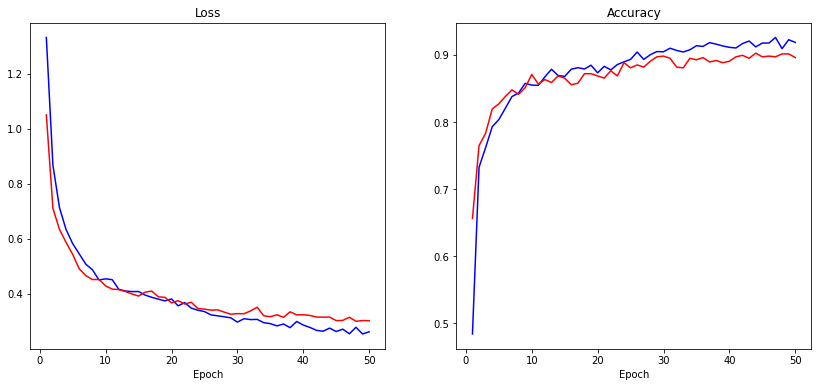

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epoch")
plt.title("Loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Epoch")
plt.title("Accuracy")

plt.show()

***Точность нашей модели 90%***

Сделаем инференс на случайных картинках и отрисуем результаты

In [21]:
classes = {v: k for k, v in valid.class_to_idx.items()}

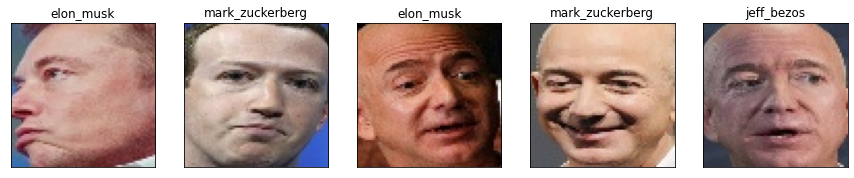

In [27]:
plt.figure(figsize=(15, 7))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    path_img = np.random.choice(glob.glob(os.path.join(PATH_VALID, '*/*.jpg')))
    img = plt.imread(path_img)
    tensor = transform_valid(Image.open(path_img))[None]
    with torch.no_grad():
        pred = model(tensor.to(device)).to('cpu').argmax().item()
    img = plt.imread(path_img)
    plt.title(classes[pred])
    plt.imshow(img)